In [1]:
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

## Data processing

### Loading documents

In [2]:
from data_processing.qdrant_loader import load_qdrant_client
qdrant_client = load_qdrant_client(host="localhost")

In [3]:
from data_processing.qdrant_loader import load_documents, upload_documents_qdrant
documents = load_documents("../data")

### Uploading to Qdrant

In [4]:
upload_documents_qdrant(documents=documents, collection_name="anchor", client=qdrant_client)

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 16033.27it/s]


Documents uploaded to Qdrant


## Retriever Evaluation

### Load Ground truth data

In [5]:
from utils.ground_truth import load_ground_truth
ground_truth = load_ground_truth("../assets/ground_truth.json")


In [6]:
from data_processing.retriever_evaluation import evaluate_search_results
from data_processing.qdrant_loader import load_qdrant_client, load_embedding



qdrant_client = load_qdrant_client(host="localhost")
embedding_model = load_embedding()

hit_rate, rate_relevance,_,_ =  evaluate_search_results(ground_truth=ground_truth["questions"], embedding_model=embedding_model, qdrant_client=qdrant_client, verbose=False)


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 52692.26it/s]


Hit_Rate: 40.00%
Average Rating: 3.1 / 5
Average Combined Rating: 1.3565032644569874 / 2.2


## RAG Evaluation

In [7]:

hit_rate, rate_relevance, ratings_4omini, combined_list_4omini  =  evaluate_search_results(ground_truth=ground_truth["questions"],
                                                    llm_model="gpt-4o-mini",
                                                    embedding_model=embedding_model, 
                                                    qdrant_client=qdrant_client, verbose=False)


Hit_Rate: 40.00%
Average Rating: 3.1 / 5
Average Combined Rating: 1.3565032644569874 / 2.2


In [8]:
hit_rate, rate_relevance, ratings_4o, combined_list_4o  =  evaluate_search_results(ground_truth=ground_truth["questions"],
                                                    llm_model="gpt-4o",
                                                    embedding_model=embedding_model, 
                                                    qdrant_client=qdrant_client, verbose=False)

Hit_Rate: 40.00%
Average Rating: 2.75 / 5
Average Combined Rating: 1.2515032644569872 / 2.2


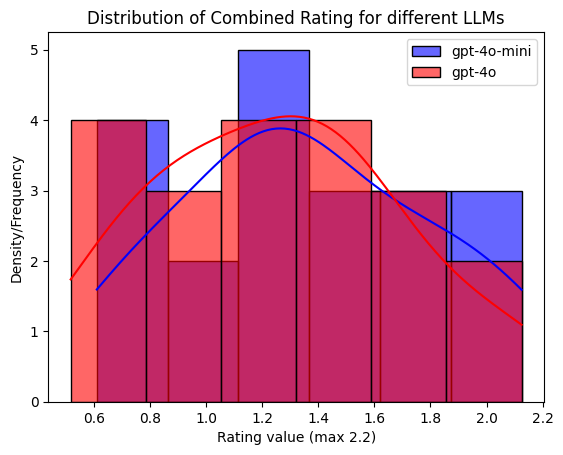

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(combined_list_4omini,  color='blue', label='gpt-4o-mini', kde=True, alpha=0.6)
sns.histplot(combined_list_4o,  color='red', label='gpt-4o', kde=True, alpha=0.6)

plt.xlabel('Rating value (max 2.2)')
plt.ylabel('Density/Frequency')
plt.title('Distribution of Combined Rating for different LLMs')

# Add legend
plt.legend()



## Re - Ranking


In [10]:
hit_rate, rate_relevance, ratings_4omini_rerank, combined_list_4omini_rerank  =  evaluate_search_results(ground_truth=ground_truth["questions"],
                                                    llm_model="gpt-4o-mini",
                                                    embedding_model=embedding_model, 
                                                    qdrant_client=qdrant_client, verbose=False, n_search_results=5, reranking=True )

Hit_Rate: 45.00%
Average Rating: 4.3 / 5
Average Combined Rating: 1.74550478041172 / 2.2


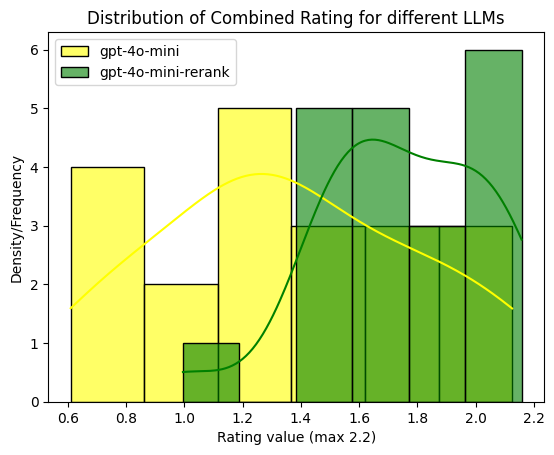

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(combined_list_4omini,  color='yellow', label='gpt-4o-mini', kde=True, alpha=0.6)
sns.histplot(combined_list_4omini_rerank,  color='green', label='gpt-4o-mini-rerank', kde=True, alpha=0.6)

plt.xlabel('Rating value (max 2.2)')
plt.ylabel('Density/Frequency')
plt.title('Distribution of Combined Rating for different LLMs')

# Add legend
plt.legend()

## Hybrid Search

In [12]:
from qdrant_client.http.models import Filter, FieldCondition, MatchValue
from utils.ground_truth import extract_text_from_node_content  

filter_conditions = Filter(
            must=[
                FieldCondition(
                    key="file_name",  # The metadata field you want to filter on
                    match=MatchValue(
                        value="GettingStartedwithAnchor.pdf"
                    ),  # The value to match in the 'category' field
                ),
            ]
        )

query = "when was anchor framework guide updated"
query_vector = embedding_model.get_text_embedding(query)

hybrid_search_results = qdrant_client.search(
        collection_name="anchor",
        query_vector=query_vector,
        query_filter=filter_conditions,  # Provide the query vector here
        limit=1,
    )

In [13]:
import textwrap

textwrap.fill(extract_text_from_node_content(hybrid_search_results[0].payload), width=70)

"Home>Developers>Guides Getting Started with the Anchor Framework\nupdated 24. April 2024 beginner rust anchor The Anchor framework uses\nRust macros to reduce boilerplate code and simplify the implementation\nof IT'S TIME TO ENTER THE ARENA 📡  - SIGN UP FOR THE SOLANA RADAR\nHACKATHON NOW!"